In [46]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
# Загрузка данных
def load_data():
    customers = pd.read_csv("./clean_data/customers.csv")
    geolocation = pd.read_csv("./clean_data/geolocation.csv")
    order_pay = pd.read_csv("./clean_data/order_payments.csv")
    reviews = pd.read_csv("./clean_data/order_reviews.csv")
    orders = pd.read_csv("./clean_data/orders.csv")
    item = pd.read_csv("./clean_data/orders_items.csv")
    category_name = pd.read_csv(
        "./clean_data/product_category_name_translation.csv")
    products = pd.read_csv("./clean_data/products.csv")
    sellers = pd.read_csv("./clean_data/sellers.csv")
    return customers, geolocation, order_pay, reviews, orders, item, category_name, products, sellers


In [48]:
# Объединение данных
def merge_data(orders, item, order_pay, reviews, products, customers, sellers, category_name):
    df = orders.merge(item, on='order_id', how='left')
    df = df.merge(order_pay, on='order_id', how='outer', validate='m:m')
    df = df.merge(reviews, on='order_id', how='outer')
    df = df.merge(products, on='product_id', how='outer')
    df = df.merge(customers, on='customer_id', how='outer')
    df = df.merge(sellers, on='seller_id', how='outer')
    df = df.merge(category_name, on="product_category_name", how="left")
    return df

In [49]:
# Очистка данных: удаление строк без customer_unique_id
def filter_customers(df):
    return df[~df["customer_unique_id"].isna()]

In [50]:
# Главная функция пайплайна
def main_pipeline():
    # Шаг 1: Загрузка данных
    customers, geolocation, order_pay, reviews, orders, item, category_name, products, sellers = load_data()

    # Шаг 2: Объединение данных
    df = merge_data(orders, item, order_pay, reviews, products,
                    customers, sellers, category_name)

    # Шаг 3: Фильтрация данных
    df = filter_customers(df)

    final_data = df

    return final_data

In [51]:
data = main_pipeline()

In [52]:
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english
0,d455a8cb295653b55abda06d434ab492,944b72539d7e1f7f7fc6e46639ef1fe3,delivered,2017-09-26 22:17:05,2017-09-27 22:24:16,2017-09-29 15:53:03,2017-10-07 16:12:47,2017-10-30 00:00:00,1.0,a2ff5a97bf95719e38ea2e3b4105bce8,...,43.0,36.0,3c7e305796add66698959fc7ad176f6b,87502.0,umuarama,PR,9080.0,santo andre,SP,small_appliances
1,7f39ba4c9052be115350065d07583cac,d7fc82cbeafea77bd0a8fbbf6296e387,delivered,2017-10-18 08:16:34,2017-10-18 23:56:20,2017-10-20 14:29:01,2017-10-27 16:46:05,2017-11-09 00:00:00,1.0,a2ff5a97bf95719e38ea2e3b4105bce8,...,43.0,36.0,9de5797cddb92598755a0f76383ddbbb,35490.0,entre rios de minas,MG,9080.0,santo andre,SP,small_appliances
2,9dc8d1a6f16f1b89874c29c9d8d30447,d9442164acf4b03109425633efaa0cfc,delivered,2017-10-12 13:33:22,2017-10-12 13:49:22,2017-10-17 15:42:42,2017-10-24 20:17:44,2017-11-06 00:00:00,1.0,a2ff5a97bf95719e38ea2e3b4105bce8,...,43.0,36.0,9915eb9f74b6c11aaf04833f65b00e93,38600.0,paracatu,MG,9080.0,santo andre,SP,small_appliances
3,0f548bd29148ebc519d6495e37a284e1,015faf9ec36eccd957c0f2782aab09a4,delivered,2017-09-03 08:06:30,2017-09-03 08:25:50,2017-09-04 22:03:06,2017-09-08 16:26:55,2017-09-27 00:00:00,1.0,08574b074924071f4e201e151b152b4e,...,12.0,39.0,dce323533e45e74d215e0fe7fb114118,24710.0,sao goncalo,RJ,29156.0,cariacica,ES,garden_tools
4,0f548bd29148ebc519d6495e37a284e1,015faf9ec36eccd957c0f2782aab09a4,delivered,2017-09-03 08:06:30,2017-09-03 08:25:50,2017-09-04 22:03:06,2017-09-08 16:26:55,2017-09-27 00:00:00,2.0,08574b074924071f4e201e151b152b4e,...,12.0,39.0,dce323533e45e74d215e0fe7fb114118,24710.0,sao goncalo,RJ,29156.0,cariacica,ES,garden_tools


---
### Предобработка данных

In [53]:
# Преобразование временных меток в datetime
data['order_purchase_timestamp'] = pd.to_datetime(
    data['order_purchase_timestamp'])

# Текущая дата для расчета давности (возьмем максимальную дату в данных как "сегодня")
current_date = data['order_purchase_timestamp'].max()

# Группировка данных по клиентам
rfm_data = data.groupby('customer_unique_id').agg({
    # Recency
    'order_purchase_timestamp': lambda x: (current_date - x.max()).days,
    'order_id': 'nunique',  # Frequency (уникальные заказы)
    'product_id': 'count'   # Monetary (общее количество товаров)
}).reset_index()

rfm_data.columns = ['customer_unique_id', 'Recency', 'Frequency', 'Monetary']

In [54]:
rfm_data.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,111.0,1,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114.0,1,1
2,0000f46a3911fa3c0805444483337064,536.0,1,1
3,0000f6ccb0745a6a4b88665a16c9f078,320.0,1,1
4,0004aac84e0df4da2b147fca70cf8255,287.0,1,1


In [55]:
rfm_data.describe()

,Recency,Frequency,Monetary
count,93342.000000,96096.000000,96096.000000
mean,236.927632,1.003798,1.204067
std,152.584210,0.268692,0.862057
min,0.000000,0.000000,0.000000
25%,113.000000,1.000000,1.000000
50%,218.000000,1.000000,1.000000
75%,345.000000,1.000000,1.000000
max,713.000000,15.000000,75.000000


---
### Расчет RFM-сегментов

In [56]:
# Убедимся, что работаем только с нужными числовыми колонками
rfm_numeric = rfm_data[['Recency', 'Frequency', 'Monetary']]

# Рассчитаем квартили только для числовых колонок
quantiles = rfm_numeric.quantile(q=[0.25, 0.5, 0.75]).to_dict()

# Функция для присвоения RFM-рангов на основе квартилей данных


def rank_rfm(x, metric, quantiles):
    """
    Параметры:
    x : float - значение метрики (Recency, Frequency, Monetary) для клиента
    metric : str - название метрики ('Recency', 'Frequency', 'Monetary')
    quantiles : dict - словарь с квартилями для всех метрик

    Возвращает:
    int - ранг от 1 до 4, где для Recency 4 - лучший, для Frequency/Monetary 4 - худший

    Примечание: 
    Для Recency используется обратная шкала (меньше дней = лучше)
    Для Frequency и Monetary - прямая шкала (больше значений = лучше)
    Квартили рассчитываются для всей популяции клиентов

    """

    # Логика ранжирования для Recency
    if metric == 'Recency':
        # Чем меньше дней прошло с последней покупки (ниже Recency), тем лучше
        if x <= quantiles[metric][0.25]:
            return 4  # Топ-25% самых активных (покупали недавно)
        elif x <= quantiles[metric][0.5]:
            return 3  # 25-50% - выше среднего
        elif x <= quantiles[metric][0.75]:
            return 2  # 50-75% - ниже среднего
        else:
            return 1  # Худшие 25% - давно не покупали

    # Логика ранжирования для Frequency и Monetary
    else:
        # Чем больше покупок/сумма (выше значения), тем лучше
        if x <= quantiles[metric][0.25]:
            return 1  # Худшие 25% - редко/мало покупают
        elif x <= quantiles[metric][0.5]:
            return 2  # 25-50% - ниже среднего
        elif x <= quantiles[metric][0.75]:
            return 3  # 50-75% - выше среднего
        else:
            return 4  # Топ-25% - самые частые/крупные покупатели


# Применим ранжирование
rfm_data['R_rank'] = rfm_data['Recency'].apply(
    rank_rfm, args=('Recency', quantiles))
rfm_data['F_rank'] = rfm_data['Frequency'].apply(
    rank_rfm, args=('Frequency', quantiles))
rfm_data['M_rank'] = rfm_data['Monetary'].apply(
    rank_rfm, args=('Monetary', quantiles))

# Создадим RFM-сегмент
rfm_data['RFM_Score'] = rfm_data['R_rank'].astype(
    str) + rfm_data['F_rank'].astype(str) + rfm_data['M_rank'].astype(str)

In [57]:
rfm_data.head()

,customer_unique_id,Recency,Frequency,Monetary,R_rank,F_rank,M_rank,RFM_Score
0,0000366f3b9a7992bf8c76cfdf3221e2,111.0,1,1,4,1,1,411
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114.0,1,1,3,1,1,311
2,0000f46a3911fa3c0805444483337064,536.0,1,1,1,1,1,111
3,0000f6ccb0745a6a4b88665a16c9f078,320.0,1,1,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,287.0,1,1,2,1,1,211


---
### Интерпретация сегментов для оттока

### 1. Структура RFM-оценки
Каждый клиент получает 3 цифры в формате `R_F_M`, где:
- **R (Recency)** - ранг давности последней покупки:
  - 4: Совсем недавно (наилучший)
  - 1: Очень давно (наихудший)
- **F (Frequency)** - ранг частоты покупок:
  - 4: Очень часто
  - 1: Очень редко
- **M (Monetary)** - ранг суммы покупок:
  - 4: Очень много тратит
  - 1: Очень мало тратит

### 2. Логика распределения по рискам

| Категория риска   | Примеры RFM-оценок      | Логика интерпретации                                                                 |
|--------------------|-------------------------|--------------------------------------------------------------------------------------|
| **Высокий риск**   | '111', '112', '121'     | Низкие ранги по всем параметрам: давно не покупал, редко покупает, малые траты       |
| **Средний риск**   | '131', '211', '213'     | Смешанные показатели: например, недавняя покупка (R=2), но низкая частота (F=1)      |
| **Низкий риск**    | '311', '333', '444'     | Высокие ранги хотя бы по одному ключевому параметру (обычно Recency)                 |



In [60]:
# Рассчитываем взвешенную RFM-оценку
weights = {'R': 0.5, 'F': 0.3, 'M': 0.2}
rfm_data['RFM_Weighted'] = (
    rfm_data['R_rank']*weights['R']
    + rfm_data['F_rank']*weights['F']
    + rfm_data['M_rank']*weights['M']
)

# Автоматическая классификация через квантили
rfm_data['Churn_Risk'] = pd.qcut(
    rfm_data['RFM_Weighted'],
    q=[0, 0.25, 0.75, 1],  # Границы квантилей
    labels=['Высокий риск', 'Средний риск', 'Низкий риск']
)

# Результат
display(rfm_data.head())

,customer_unique_id,Recency,Frequency,Monetary,R_rank,F_rank,M_rank,RFM_Score,RFM_Weighted,Churn_Risk
0,0000366f3b9a7992bf8c76cfdf3221e2,111.0,1,1,4,1,1,411,2.5,Средний риск
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114.0,1,1,3,1,1,311,2.0,Средний риск
2,0000f46a3911fa3c0805444483337064,536.0,1,1,1,1,1,111,1.0,Высокий риск
3,0000f6ccb0745a6a4b88665a16c9f078,320.0,1,1,2,1,1,211,1.5,Высокий риск
4,0004aac84e0df4da2b147fca70cf8255,287.0,1,1,2,1,1,211,1.5,Высокий риск


---
### Визуализация результатов

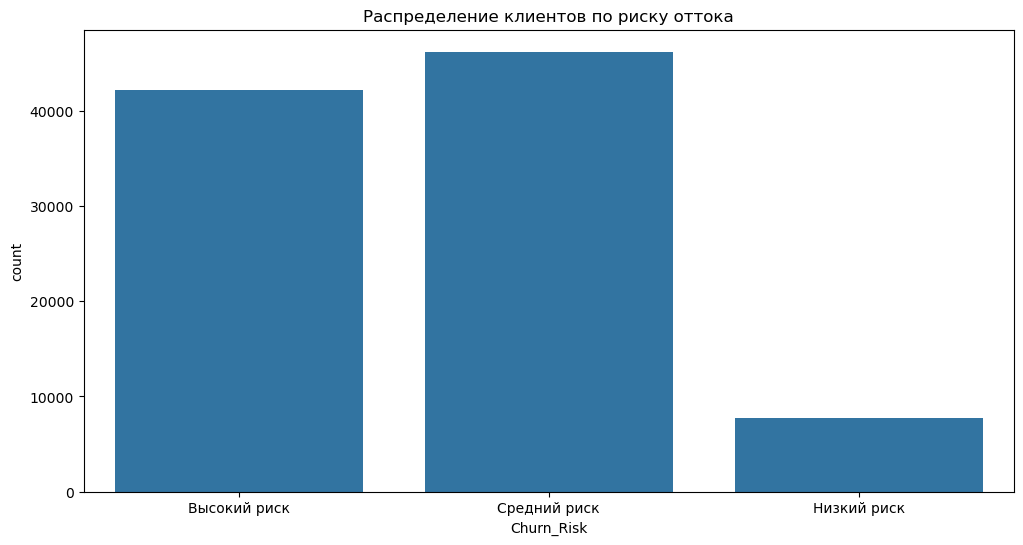

In [64]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Churn_Risk', data=rfm_data, order=[
              'Высокий риск', 'Средний риск', 'Низкий риск'])
plt.title('Распределение клиентов по риску оттока')
plt.show()

In [68]:
# Проверка распределения
risk_distribution = rfm_data['Churn_Risk'].value_counts(
    normalize=True).sort_index()
print("\nРаспределение клиентов по рискам:")
print(risk_distribution)


Распределение клиентов по рискам:
Churn_Risk
Высокий риск    0.439019
Средний риск    0.480852
Низкий риск     0.080128
Name: proportion, dtype: float64


---
### Используем Churn_risk как разметку для классификатора (для классификации клиента в режиме онлайн без этапа RFM)

In [69]:
rfm_labels = rfm_data.copy()[["customer_unique_id", "Churn_Risk"]]
rfm_labels["Churn_Risk"] = rfm_labels["Churn_Risk"].map(
    {"Высокий риск": 3, "Средний риск": 2, "Низкий риск": 1})

rfm_labels

,customer_unique_id,Churn_Risk
0,0000366f3b9a7992bf8c76cfdf3221e2,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2
2,0000f46a3911fa3c0805444483337064,3
3,0000f6ccb0745a6a4b88665a16c9f078,3
4,0004aac84e0df4da2b147fca70cf8255,3
...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,2
96092,fffea47cd6d3cc0a88bd621562a9d061,3
96093,ffff371b4d645b6ecea244b27531430a,3
96094,ffff5962728ec6157033ef9805bacc48,2


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")


# Загрузка данных (в будущем этот и следующий шаг можно заменить на выгрузку sql)
def load_data():
    customers = pd.read_csv("./clean_data/customers.csv")
    geolocation = pd.read_csv("./clean_data/geolocation.csv")
    order_pay = pd.read_csv("./clean_data/order_payments.csv")
    reviews = pd.read_csv("./clean_data/order_reviews.csv")
    orders = pd.read_csv("./clean_data/orders.csv")
    item = pd.read_csv("./clean_data/orders_items.csv")
    category_name = pd.read_csv(
        "./clean_data/product_category_name_translation.csv")
    products = pd.read_csv("./clean_data/products.csv")
    sellers = pd.read_csv("./clean_data/sellers.csv")
    return customers, geolocation, order_pay, reviews, orders, item, category_name, products, sellers


# Объединение данных
def merge_data(orders, item, order_pay, reviews, products, customers, sellers, category_name):
    df = orders.merge(item, on='order_id', how='left')
    df = df.merge(order_pay, on='order_id', how='outer', validate='m:m')
    df = df.merge(reviews, on='order_id', how='outer')
    df = df.merge(products, on='product_id', how='outer')
    df = df.merge(customers, on='customer_id', how='outer')
    df = df.merge(sellers, on='seller_id', how='outer')
    df = df.merge(category_name, on="product_category_name", how="left")
    return df

# Очистка данных: удаление строк без customer_unique_id


def filter_customers(df):
    return df[~df["customer_unique_id"].isna()]


def calculate_rfm(df):
    """Расчет RFM-метрик с обработкой исключений"""
    try:
        df['order_purchase_timestamp'] = pd.to_datetime(
            df['order_purchase_timestamp'])
        current_date = df['order_purchase_timestamp'].max()

        return df.groupby('customer_unique_id').agg(
            Recency=(
                'order_purchase_timestamp',
                lambda x: (current_date - x.max()).days),
            Frequency=('order_id', 'nunique'),
            Monetary=('product_id', 'count')
        ).reset_index()
    except KeyError as e:
        print(f"Ошибка: Отсутствует необходимая колонка {e}")
        return pd.DataFrame()


def add_rfm_segments(rfm_data):
    """Добавление RFM-сегментов с весами"""
    quantiles = rfm_data[['Recency', 'Frequency', 'Monetary']].quantile(
        [0.25, 0.5, 0.75]).to_dict()

    def rank_rfm(x, metric):
        """
        Параметры:
        x : float - значение метрики (Recency, Frequency, Monetary) для клиента
        metric : str - название метрики ('Recency', 'Frequency', 'Monetary')
        quantiles : dict - словарь с квартилями для всех метрик

        Возвращает:
        int - ранг от 1 до 4, где для Recency 4 - лучший, для Frequency/Monetary 4 - худший

        Примечание: 
        Для Recency используется обратная шкала (меньше дней = лучше)
        Для Frequency и Monetary - прямая шкала (больше значений = лучше)
        Квартили рассчитываются для всей популяции клиентов

        """

        # Логика ранжирования для Recency
        if metric == 'Recency':
            # Чем меньше дней прошло с последней покупки (ниже Recency), тем лучше
            if x <= quantiles[metric][0.25]:
                return 4  # Топ-25% самых активных (покупали недавно)
            elif x <= quantiles[metric][0.5]:
                return 3  # 25-50% - выше среднего
            elif x <= quantiles[metric][0.75]:
                return 2  # 50-75% - ниже среднего
            else:
                return 1  # Худшие 25% - давно не покупали

        # Логика ранжирования для Frequency и Monetary
        else:
            # Чем больше покупок/сумма (выше значения), тем лучше
            if x <= quantiles[metric][0.25]:
                return 1  # Худшие 25% - редко/мало покупают
            elif x <= quantiles[metric][0.5]:
                return 2  # 25-50% - ниже среднего
            elif x <= quantiles[metric][0.75]:
                return 3  # 50-75% - выше среднего
            else:
                return 4  # Топ-25% - самые частые/крупные покупатели

    for metric in ['Recency', 'Frequency', 'Monetary']:
        rfm_data[f'{metric[0]}_rank'] = rfm_data[metric].apply(
            rank_rfm, metric=metric)

    # Взвешенная оценка
    weights = {'R': 0.5, 'F': 0.3, 'M': 0.2}
    rfm_data['RFM_Weighted'] = sum(
        rfm_data[f'{k}_rank']*v for k, v in weights.items())

    # Автоматическая классификация
    rfm_data['Churn_Risk'] = pd.qcut(
        rfm_data['RFM_Weighted'],
        q=[0, 0.25, 0.75, 1],
        labels=['3_high', '2_medium', '1_low']  # Формат для сортировки
    )
    return rfm_data


def save_churn_plot(rfm_data, filename='plots/churn_risk_distribution.png'):
    """Сохранение графика распределения рисков оттока"""
    try:
        # Создаем директорию если нужно
        os.makedirs(os.path.dirname(filename), exist_ok=True)

        plt.figure(figsize=(12, 6))
        ax = sns.countplot(
            x='Churn_Risk',
            data=rfm_data,
            order=['Высокий риск', 'Средний риск', 'Низкий риск'],
            palette={'Высокий риск': 'red',
                     'Средний риск': 'orange', 'Низкий риск': 'green'}
        )

        # Добавляем аннотации
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.0f}',
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center',
                        va='center',
                        xytext=(0, 5),
                        textcoords='offset points')

        plt.title('Распределение клиентов по риску оттока')
        plt.xlabel('Категория риска')
        plt.ylabel('Количество клиентов')
        plt.xticks(rotation=45)

        # Сохраняем и закрываем график
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.close()
        print(f'График сохранен в {filename}')

    except Exception as e:
        print(f'Ошибка при сохранении графика: {str(e)}')

def save_labels(label_data, filename='labels/labels.csv'):
    try:
        # Создаем директорию если нужно
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        label_data.to_csv(filename, index=False)
        
    except Exception as e:
        print(f'Ошибка при сохранении лэйблов: {str(e)}')
    pass

def main_pipeline():
    """Главный конвейер обработки данных"""
    # Шаг 1: Загрузка данных
    customers, geolocation, order_pay, reviews, orders, item, category_name, products, sellers = load_data()

    # Шаг 2: Объединение данных
    df = merge_data(orders, item, order_pay, reviews, products,
                    customers, sellers, category_name)

    # Шаг 3: Фильтрация пропусков
    data = filter_customers(df)

    # Шаг 4: Расчет rfm
    rfm_raw = calculate_rfm(data)

    # Шаг 5: Объединение данных
    rfm_segment = add_rfm_segments(rfm_raw)
    
    # Шаг 6: Сохраняем график для дашборда
    save_churn_plot(rfm_segment, 'results/plots/churn_distribution.png')
    
    # Шаг 7: Вычленяем лэйблы для классификации
    label_data = rfm_segment.copy()[['customer_unique_id', 'Churn_Risk']]
    risk_mapping = {'3_high': 3, '2_medium': 2, '1_low': 1}
    label_data['Churn_Risk'] = label_data['Churn_Risk'].map(risk_mapping)
    
    # Шаг 8: Сохранение лэйблов для обучения классификатора
    save_labels(label_data,'results/labels/labels.csv')

    return rfm_segment, label_data


# Запуск пайплайна и вывод результатов
if __name__ == "__main__":
    rfm_result, label_data  = main_pipeline()

    print("\nПример данных:")
    display(rfm_result.head(3))

    print("\nРаспределение классов:")
    print(label_data['Churn_Risk'].value_counts(normalize=True).sort_index())

    print("\nПервые 5 записей для классификатора:")
    display(label_data.head())

График сохранен в results/plots/churn_distribution.png

Пример данных:


,customer_unique_id,Recency,Frequency,Monetary,R_rank,F_rank,M_rank,RFM_Weighted,Churn_Risk
0,0000366f3b9a7992bf8c76cfdf3221e2,111.0,1,1,4,1,1,2.5,2_medium
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114.0,1,1,3,1,1,2.0,2_medium
2,0000f46a3911fa3c0805444483337064,536.0,1,1,1,1,1,1.0,3_high



Распределение классов:
Churn_Risk
3    0.439019
2    0.480852
1    0.080128
Name: proportion, dtype: float64

Первые 5 записей для классификатора:


,customer_unique_id,Churn_Risk
0,0000366f3b9a7992bf8c76cfdf3221e2,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2
2,0000f46a3911fa3c0805444483337064,3
3,0000f6ccb0745a6a4b88665a16c9f078,3
4,0004aac84e0df4da2b147fca70cf8255,3
